<a href="https://colab.research.google.com/github/NesquikPlz/Conditional_VAE_for_celebA/blob/main/implement_Conditional_VAE_for_celebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Conditional Variational Auto Encoder for CelebA Dataset
<br>
* This code is based on : <br>
CVAE >> https://www.kaggle.com/nadergo/conditional-vae-on-faces
<br>
Load Image >> https://colab.research.google.com/drive/1E9SS-QwdXwsjNoAXJ_ea4if2sTksq3LZ?usp=sharing


###1. Setting up

In [ ]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install natsort==7.1.0 Pillow==8.0.1 gdown

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import torch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch.optim as  optim 

In [ ]:
#fix the random seed absolutely
manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [ ]:
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

device

device(type='cpu')

###2. Load DataSet

In [ ]:
from torchvision import transforms, datasets

In [ ]:
import os
import zipfile

import gdown

from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image

In [ ]:
"""Download the CelebA Dataset_Image"""

# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with individual images
img_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url_picture = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(img_folder)

# Download the dataset from google drive
gdown.download(url_picture, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(img_folder)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:13<00:00, 108MB/s]


In [ ]:
"""Download the CelebA Dataset_Attribute"""

# same as above . . .
img_folder = f'{data_root}/list_attr_celeba'
# URL for the CelebA Data Attribute (ex : have mustache or not . . .)
url_attr = 'https://drive.google.com/u/0/uc?id=1knTW6f0Zr6ED-kldEoWnz64-GaNEjtkH'
# Path to download the dataset to
download_path = f'{img_folder}/list_attr_celeba.csv'

if not os.path.exists(img_folder):
  os.makedirs(img_folder)

gdown.download(url_attr, download_path, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1knTW6f0Zr6ED-kldEoWnz64-GaNEjtkH
To: /content/data/celeba/list_attr_celeba/list_attr_celeba.csv
100%|██████████| 24.9M/24.9M [00:00<00:00, 105MB/s]


'data/celeba/list_attr_celeba/list_attr_celeba.csv'

###3. Data Preprocessing

####3.1 Image Data

In [ ]:
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names) #sort filenames

  #returns the number of images
  def __len__(self): 
    return len(self.image_names)

  
  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)
    return img

In [ ]:
# choose image size, default = 64
image_size = 64
# Transformations to be applied to each individual image sample
# transform : can edit a specific row/col in dataframe(similar with apply(), but applied on a single row/col)
# compose : can handle data at once easily
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                       std=[0.5, 0.5, 0.5])
])
# Load the dataset and apply transformations
img_folder = f'{data_root}/img_align_celeba'
celeba_dataset = CelebADataset(f'{img_folder}/img_align_celeba', transform)

In [ ]:
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

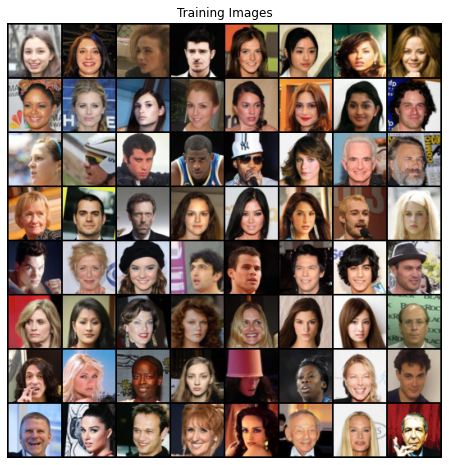

In [ ]:
real_batch = next(iter(celeba_dataloader))
image_grid = vutils.make_grid(real_batch.to(device)[:64],
                              padding=2,
                              normalize=True).cpu()

image_grid = np.transpose(image_grid, (1, 2, 0))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(image_grid)

####3.2 Attribute Data

In [ ]:
attr_csv = pd.read_csv("../content/data/celeba/list_attr_celeba/list_attr_celeba.csv", error_bad_lines=False)

In [ ]:
def haircolor(x) :
  if x["Blond_Hair"] == 1 :
    return 0
  elif x["Brown_Hair"] == 1 :
    return 1
  elif x["Black_Hair"] == 1 :
    return 2
  else :
    return 3

attr_csv["Hair_Color"] = attr_csv.apply(haircolor, axis = 1)

In [ ]:
#For the simplicity, I used total 5 attributes
attr_use = attr_csv[["Id","Hair_Color",'Pale_Skin',"Male","No_Beard", "Young"]].copy()
attr_use

,Id,Hair_Color,Pale_Skin,Male,No_Beard,Young
0,000001.jpg,1,-1,-1,1,1
1,000002.jpg,1,-1,-1,1,1
2,000003.jpg,3,-1,1,1,1
3,000004.jpg,3,-1,-1,1,1
4,000005.jpg,3,-1,-1,1,1
...,...,...,...,...,...,...
202594,202595.jpg,0,-1,-1,1,1
202595,202596.jpg,0,1,1,1,1
202596,202597.jpg,2,-1,1,1,1
202597,202598.jpg,2,-1,-1,1,1


In [ ]:
#replace -1 with
attr_use['Pale_Skin'] = attr_use.Pale_Skin.apply(lambda x: max(x,0)) 
attr_use['Male'] = attr_use.Male.apply(lambda x: max(x,0))
attr_use['No_Beard'] = attr_use.No_Beard.apply(lambda x: max(x,0))
attr_use['Young'] = attr_use.Young.apply(lambda x: max(x,0))

In [ ]:
attr_use

,Id,Hair_Color,Pale_Skin,Male,No_Beard,Young
0,000001.jpg,1,0,0,1,1
1,000002.jpg,1,0,0,1,1
2,000003.jpg,3,0,1,1,1
3,000004.jpg,3,0,0,1,1
4,000005.jpg,3,0,0,1,1
...,...,...,...,...,...,...
202594,202595.jpg,0,0,0,1,1
202595,202596.jpg,0,1,1,1,1
202596,202597.jpg,2,0,1,1,1
202597,202598.jpg,2,0,0,1,1


###4. Model Implementation

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Encoder,self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size*3//2,stride,padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size*3//2,stride,padding)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size*2,stride*2,padding)
        self.conv4 = nn.Conv2d(out_channels, out_channels*2, kernel_size*2,stride*2,padding)
        self.maxpool1 = nn.MaxPool2d(kernel_size=kernel_size, stride=stride*2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=kernel_size, stride=stride*2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=kernel_size, stride=stride*2)
        self.maxpool4 = nn.MaxPool2d(kernel_size=kernel_size, stride=stride*2)

    def forward(self,x):
        out = self.conv1(x)
        out = self.maxpool1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.maxpool2(out)
        out = F.relu(out)

        out = self.conv3(out)
        out = self.maxpool3(out)
        out = F.relu(out)

        out= self.conv4(out)
        out = self.maxpool4(out)
        out = F.relu(out)
        return out.view(out.shape[0],-1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, attributes, in_channels, out_channels, kernel_size, stride, padding):
        super(Decoder,self).__init__()
        #attributes : the number of the image labels (if y has 5 attributes, then 5)
        #for upsampling, we use Transpose Convolution Layers

        self.transconv1 = nn.ConvTranspose2d(in_channels+attributes*10, in_channels, kernel_size*2, stride*2, padding*2)
        self.transconv2 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size*2, stride*2, padding*2)
        self.transconv3 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size, stride, padding)
        self.transconv4 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        
        """
        Every attribute is converted into vector such as . . .
        Beard or no beard -> vector of 10 weights
        Male or Female -> vector of 10 weights 
        """
        self.hairEmbedding = nn.Embedding(4,10)
        self.beardEmbedding = nn.Embedding(2,10)
        self.genderEmbedding = nn.Embedding(2,10)
        self.paleSkinEmbedding = nn.Embedding(2,10)
        self.youngEmbedding = nn.Embedding(2,10)

        self.dim = in_channels
        
    def forward(self, x):
        # Embed y in z
        z = x[:,:self.dim]
        hair = self.hairEmbedding(x[:,self.dim].long())
        paleSkin = self.paleSkinEmbedding(x[:,self.dim+1].long())
        gender = self.genderEmbedding(x[:,self.dim+2].long())
        beard = self.beardEmbedding(x[:,self.dim+3].long())
        young = self.youngEmbedding(x[:,self.dim+4].long())
        """
        Concating the embeddings and the encoded image
        """
        z = torch.cat([z,hair,beard,gender,paleSkin,young],dim=1)
        
        out= self.transconv1(z.view(z.shape[0],z.shape[1],1,1))
        out = F.relu(out)
        out= self.transconv2(out)
        out = F.relu(out)
        out= self.transconv3(out)
        out = F.relu(out)
        out= self.transconv4(out)
        out = F.relu(out)

        return out

In [ ]:
class CVAE(nn.Module):
    def __init__(self,encoder,decoder, attributes,
                 E_in_channels, E_out_channels, E_kernel_size, E_stride, E_padding,
                 D_in_channels, D_out_channels, D_kernel_size, D_stride, D_padding
                 ):
        super(CVAE,self).__init__()
        self.encoder = encoder(E_in_channels, E_out_channels, E_kernel_size, E_stride, E_padding)
        self.decoder = decoder(attributes, D_in_channels, D_out_channels, D_kernel_size, D_stride, D_padding)
        self.dim = E_out_channels
        
    def forward(self, x, attr):
        h = self.encoder(x)
        mu = h[:,:self.dim]
        logvar = h[:,self.dim:]
        # this part is for the reparameterization trick
        s= torch.exp(logvar)
        eps = torch.randn_like(s)
        z = s*eps + mu 
        
        z= torch.cat([z,attr],dim=1)
        out = self.decoder(z)
        return out,mu,logvar
      

###5. Training

In [ ]:
vae = CVAE(Encoder,Decoder, attributes=5,
          E_in_channels=3, E_out_channels=64, E_kernel_size=2, E_stride=1, E_padding=1,
          D_in_channels=64, D_out_channels=3, D_kernel_size=4, D_stride=2, D_padding=1
          )
vae.to(device)

CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (transconv1): ConvTranspose2d(114, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv2): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), pa

In [ ]:
def loss_function(recon_x,x,mu,logvar):
    #loss = Reconstruction error + KL-divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= x.shape[0] * 3 * 64 * 64
    recon_loss = F.mse_loss(recon_x,x)
    return recon_loss, KLD

epochs = 10
learning_rate = 0.001

optimizer = optim.Adagrad(vae.parameters(),lr = learning_rate)
# npData = df.iloc[:20000].to_numpy()

# n_samples = len(npData)
# better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))
# losstrack = []
# recontrack = []
# kldtrack = []
for e in range(epochs):
    losses = []
    recons = []
    klds = []
    for i, image in enumerate(celeba_dataloader):
        batch_size = len(image)
        batch = attr_use[i * batch_size: (i+1) * batch_size]
        attrs = torch.Tensor(batch.iloc[:, 1:].values).to(device)
        vae.zero_grad()
        recon_imgs,mu,logvar = vae(image, attrs)
        recon, kld = loss_function(recon_imgs,image,mu,logvar)

        err = recon+kld
        err.backward()
        optimizer.step()

        losses.append(err.item())
        recons.append(recon.item())
        klds.append(kld.item())
    
        if i % 50 == 0:
            losstrack.append(np.mean(losses))
            recontrack.append(np.mean(recons))
            kldtrack.append(np.mean(klds))
            print(
                f'[{e}/{epochs - 1}][{i}/{len(celeba_dataloader)}]\t\t Loss:{np.mean(losses).item():4f} \t>>\t Reconstruction Error:{np.mean(recons).item():4f}\t KL-divergence:{np.mean(klds):4f}'
            )

    if e % 10 == 0: 
        torch.save(vae.state_dict(), "./cvae.pt")


[0/9][0/1583]		 Loss:0.033360 	>>	 Reconstruction Error:0.028343	 KL-divergence:0.005017
[0/9][50/1583]		 Loss:0.065546 	>>	 Reconstruction Error:0.060326	 KL-divergence:0.005220
[0/9][100/1583]		 Loss:0.049412 	>>	 Reconstruction Error:0.044360	 KL-divergence:0.005052
[0/9][150/1583]		 Loss:0.043804 	>>	 Reconstruction Error:0.038832	 KL-divergence:0.004972
[0/9][200/1583]		 Loss:0.040931 	>>	 Reconstruction Error:0.036008	 KL-divergence:0.004924
[0/9][250/1583]		 Loss:0.039231 	>>	 Reconstruction Error:0.034330	 KL-divergence:0.004901
[0/9][300/1583]		 Loss:0.038065 	>>	 Reconstruction Error:0.033193	 KL-divergence:0.004872
[0/9][350/1583]		 Loss:0.037247 	>>	 Reconstruction Error:0.032391	 KL-divergence:0.004856
[0/9][400/1583]		 Loss:0.036594 	>>	 Reconstruction Error:0.031749	 KL-divergence:0.004845
[0/9][450/1583]		 Loss:0.036104 	>>	 Reconstruction Error:0.031266	 KL-divergence:0.004838
[0/9][500/1583]		 Loss:0.035694 	>>	 Reconstruction Error:0.030863	 KL-divergence:0.004831
[0

###6. Plot Losses

In [ ]:
torch.save(vae.state_dict(), "../content/drive/MyDrive/dataset/cvae_15epochs.pt")

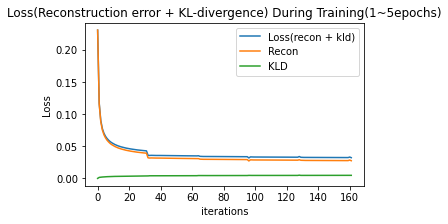

In [ ]:
plt.figure(figsize=(5, 3))
plt.title("Loss(Reconstruction error + KL-divergence) During Training(1~5epochs)")
plt.plot(losstrack, label="Loss(recon + kld)")
plt.plot(recontrack, label="Recon")
plt.plot(kldtrack, label="KLD")
plt.xlabel("iterations")
device
plt.ylabel("Loss")
plt.legend()
plt.show()

hair,beard,gender,paleSkin,young

In [ ]:
def showImage(x):
    attrs = torch.Tensor(x)
    h = torch.cat((torch.randn(1,64),attrs),dim=1).to(device)
    img = vae.decoder(h)
    img = img.cpu().detach().numpy().reshape(3,64,64)
    img = np.moveaxis(img,0,-1)
    return img

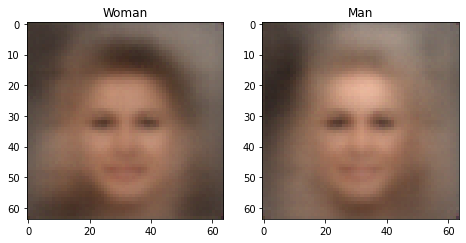

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,1,0]]))
axarr[0].set_title("Woman")
axarr[1].imshow(showImage([[2,0,1,0,0]]))
axarr[1].set_title("Man")

f.subplots_adjust(hspace=0.3,left=2,right=3)

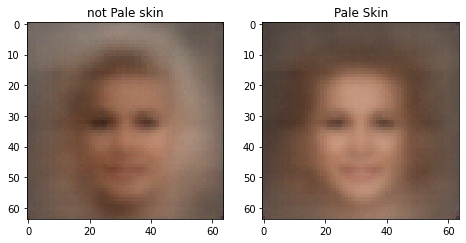

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,1, 1]]))
axarr[0].set_title("not Pale skin")
axarr[1].imshow(showImage([[2,1,0,1, 1]]))
axarr[1].set_title("Pale Skin")

f.subplots_adjust(hspace=0.3,left=2,right=3)

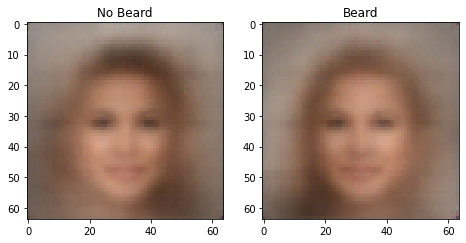

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,1,1,0]]))
axarr[0].set_title("No Beard")
axarr[1].imshow(showImage([[2,0,1,0,0]]))
axarr[1].set_title("Beard")

f.subplots_adjust(hspace=0.3,left=2,right=3)